### NER

### データ準備

In [1]:
import pickle # ピクル
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

##### 'r': 読み取り専用 (デフォルト)
##### 'w': 書き込み専用（既存のファイル内容は消去）
##### 'a': 追記モード
##### 'b': バイナリーモード（例: 'rb', 'wb'）

### データをロード

In [2]:
def load_dataset(sentences_file_name='ner_dataset_sentences.txt', label_file_name='ner_dataset_labels.txt'):
    with open(sentences_file_name, 'rb') as fp: # rbはバイナリーファイルの時
       sentence = pickle.load(fp) # 開いた後のものを引数に入れる
    
    with open(label_file_name, 'rb') as fp: # rbはバイナリーファイルの時
       labels = pickle.load(fp)
    return sentence, labels


In [3]:
sentences, labels = load_dataset()

In [4]:
sentences[:10]

['The cat sat on the mat .',
 'John lives in New York .',
 'I have two dogs .',
 'She works at Google .',
 'The Eiffel Tower is in Paris .',
 'He is from Spain .',
 'I visited the Great Wall of China .',
 'She is studying at Oxford University .',
 'He works for the United Nations .',
 'Berlin is the capital of Germany .']

In [5]:
labels[:10]

[['O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['B-per', 'O', 'O', 'B-geo', 'I-geo', 'O'],
 ['O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'B-org', 'O'],
 ['O', 'B-geo', 'I-geo', 'O', 'O', 'B-geo', 'O'],
 ['O', 'O', 'O', 'B-geo', 'O'],
 ['O', 'O', 'O', 'B-geo', 'I-geo', 'I-geo', 'I-geo', 'O'],
 ['O', 'O', 'O', 'O', 'B-org', 'I-org', 'O'],
 ['O', 'O', 'O', 'O', 'B-org', 'I-org', 'O'],
 ['B-geo', 'O', 'O', 'O', 'O', 'B-geo', 'O']]

### ラベルエンコード

### 補足 : padding用に1を足す

In [7]:
print(labels[0])
print(sentences[0])
label_encoder.transform(labels[0]) +1

['O', 'O', 'O', 'O', 'O', 'O', 'O']
The cat sat on the mat .


array([7, 7, 7, 7, 7, 7, 7])

### 辞書作成とエンコード

In [8]:
# 辞書初期化
word2indx = {"<PAD>":0}

In [9]:
encorded_sentences = []
for sentence in sentences:
    encorded_sentence = [word2indx.setdefault(word, len(word2indx)) for word in sentence.split()]
    encorded_sentences.append(encorded_sentence)

In [10]:
encorded_sentences[:10]

[[1, 2, 3, 4, 5, 6, 7],
 [8, 9, 10, 11, 12, 7],
 [13, 14, 15, 16, 7],
 [17, 18, 19, 20, 7],
 [1, 21, 22, 23, 10, 24, 7],
 [25, 23, 26, 27, 7],
 [13, 28, 5, 29, 30, 31, 32, 7],
 [17, 23, 33, 19, 34, 35, 7],
 [25, 18, 36, 5, 37, 38, 7],
 [39, 23, 5, 40, 31, 41, 7]]

### 学習データとテストデータに分割

In [11]:
X_train, X_val, y_train, y_val, train_sentenses, val_sentences = train_test_split(encorded_sentences, encoded_labels, sentences, test_size=0.2, random_state=42) 

In [12]:
X_train[:3]

[[94, 51, 95, 96, 97, 98, 7], [17, 18, 19, 87, 7], [1, 50, 51, 52, 10, 53, 7]]

In [13]:
train_sentenses[:3]

['They are visiting London this summer .',
 'She works at Facebook .',
 'The Pyramids are located in Egypt .']

### Padding

In [14]:
seq1 = torch.tensor([1, 2, 3])
seq2 = torch.tensor([4, 5])
seq3 = torch.tensor([6, 7, 8, 9])

In [15]:
sequence = [seq1, seq2, seq3]
padding_sequence = pad_sequence(sequence, batch_first=True)
print(padding_sequence)

tensor([[1, 2, 3, 0],
        [4, 5, 0, 0],
        [6, 7, 8, 9]])


In [16]:
X_train = pad_sequence([torch.tensor(x) for x in X_train], batch_first=True) # リストの中身はtensorである必要があるのでtorch.tensor(x)の処理が必要
X_val = pad_sequence([torch.tensor(x) for x in X_val], batch_first=True)  # ここではfor文各文章を取り出しでpaddingを行っている(デォルトで0padding)
y_train = pad_sequence([torch.tensor(y) for y in y_train], batch_first=True)
y_val = pad_sequence([torch.tensor(y) for y in y_val], batch_first=True)

In [17]:
X_train # paddingされている

tensor([[ 94,  51,  95,  96,  97,  98,   7,   0,   0,   0],
        [ 17,  18,  19,  87,   7,   0,   0,   0,   0,   0],
        [  1,  50,  51,  52,  10,  53,   7,   0,   0,   0],
        [  1,   2,   3,   4,   5,   6,   7,   0,   0,   0],
        [  1,  21,  22,  23,  10,  24,   7,   0,   0,   0],
        [ 25,  23,  60,  61,  24,  36,  62,  63,   7,   0],
        [ 25,  23,  26,  27,   7,   0,   0,   0,   0,   0],
        [  1,  54,  55,  23,  10,  56,   7,   0,   0,   0],
        [  1,  47,  23,   5,  48,  49,  10,   5,  46,   7],
        [  1,  82,  22,  31,  83,  23,  10,  84,   7,   0],
        [  8,   9,  10,  11,  12,   7,   0,   0,   0,   0],
        [ 13,  14,  15,  16,   7,   0,   0,   0,   0,   0],
        [  1,  88,  89,  23,  10,  90,   7,   0,   0,   0],
        [ 17,  18,  19,  20,   7,   0,   0,   0,   0,   0],
        [ 78,  79,  80,  62,  81,   7,   0,   0,   0,   0],
        [ 17,  23,  33,  19,   5,  35,  31,  91,   7,   0],
        [ 25,  67,  19,  68,   7,   0,  

In [18]:
word2indx

{'<PAD>': 0,
 'The': 1,
 'cat': 2,
 'sat': 3,
 'on': 4,
 'the': 5,
 'mat': 6,
 '.': 7,
 'John': 8,
 'lives': 9,
 'in': 10,
 'New': 11,
 'York': 12,
 'I': 13,
 'have': 14,
 'two': 15,
 'dogs': 16,
 'She': 17,
 'works': 18,
 'at': 19,
 'Google': 20,
 'Eiffel': 21,
 'Tower': 22,
 'is': 23,
 'Paris': 24,
 'He': 25,
 'from': 26,
 'Spain': 27,
 'visited': 28,
 'Great': 29,
 'Wall': 30,
 'of': 31,
 'China': 32,
 'studying': 33,
 'Oxford': 34,
 'University': 35,
 'for': 36,
 'United': 37,
 'Nations': 38,
 'Berlin': 39,
 'capital': 40,
 'Germany': 41,
 'Mount': 42,
 'Everest': 43,
 'highest': 44,
 'peak': 45,
 'world': 46,
 'Nile': 47,
 'longest': 48,
 'river': 49,
 'Pyramids': 50,
 'are': 51,
 'located': 52,
 'Egypt': 53,
 'Sahara': 54,
 'desert': 55,
 'Africa': 56,
 'work': 57,
 'Microsoft': 58,
 'Australia': 59,
 'going': 60,
 'to': 61,
 'a': 62,
 'meeting': 63,
 'Amazon': 64,
 'largest': 65,
 'rainforest': 66,
 'studied': 67,
 'Harvard': 68,
 'Mona': 69,
 'Lisa': 70,
 'famous': 71,
 'painti

### NERのモデル

In [19]:
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, num_layers=1, rnn_type='LSTM', bidirectional=False):

        super().__init__()
        self.num_directions = 2 if bidirectional else 1
        
        # embedding layer追加 (vocab_size x embedding_dim)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0) # vocab_sizeはdatasetの単語数(one-hotにするため)
        input_size = embedding_dim
        
        if rnn_type == 'RNN':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        else:
            raise ValueError('Unsupported RNN type. Choose from ["LSTM", "RNN", "GRU"]')
            
        self.fc = nn.Linear(hidden_size*self.num_directions, output_size)
        self._wight_initialize()

    def _wight_initialize(self):
        """
        パラメータの初期を行うようにする関数.
        コンストラクタとして実行
        """
        # ネストが深い...
        for name, module in self.named_modules():
            if name:
                
                if isinstance(module, nn.Linear):
                    nn.init.kaiming_normal_(module.weight)
                    
                if isinstance(module, (nn.RNN, nn.LSTM, nn.GRU)):
                    for param_name, param in module.named_parameters():
                        if 'weight' in param_name:
                            nn.init.xavier_normal_(param)  
                            
            

    def forward(self, x):
        x = self.embedding(x)
        output_seq, _ = self.rnn(x)

        # many to many の場合は，
        # output_seq: [batch_size, seq_len, hidden_size*num_directions]
        out = self.fc(output_seq)
        return out

In [20]:
# BiRNNのテスト
print(f"X_train.shape = {X_train.shape}")
vocab_size = 300
embedding_dim = 50
hidden_size = 3
batch_size = 24
output_size = 3
model = Model(vocab_size, embedding_dim, hidden_size, output_size, bidirectional=True)
out = model(X_train) # embedding layerは入力にインデックスの羅列を受け取るので適当にinput_tensorは使えない
print(f"out.shape = {out.shape}")
out

X_train.shape = torch.Size([24, 10])
out.shape = torch.Size([24, 10, 3])


tensor([[[ 0.7721, -0.0850,  0.3065],
         [ 0.9257,  0.1119,  0.0996],
         [ 0.9681, -0.0268,  0.2092],
         [ 0.5627, -0.6584,  0.1585],
         [ 0.8404,  0.4790, -0.0400],
         [ 0.6430, -0.3681,  0.3938],
         [ 0.6237, -0.2489,  0.3883],
         [ 0.5946, -0.0534,  0.1875],
         [ 0.6403,  0.0482,  0.1489],
         [ 0.6500,  0.1407,  0.1076]],

        [[ 0.1615, -0.4244,  0.2846],
         [ 0.0780, -0.1786,  0.1550],
         [-0.5420, -0.6880,  0.2974],
         [ 0.3159, -0.0741, -0.0406],
         [ 0.0861, -0.4723,  0.2568],
         [ 0.2703, -0.3629,  0.3187],
         [ 0.4789, -0.1758,  0.2769],
         [ 0.5940, -0.0401,  0.2245],
         [ 0.6451,  0.0586,  0.1739],
         [ 0.6562,  0.1504,  0.1222]],

        [[ 0.1731, -0.5538,  0.5614],
         [ 0.0939, -0.3702,  0.2788],
         [ 0.4108, -0.3026,  0.4020],
         [ 0.6419, -0.5644,  0.4218],
         [-0.0036, -0.9570,  0.6572],
         [-0.3829, -0.6575,  0.2553],
        

In [21]:
out.shape # [batch_size, seq_len(今回はdataset内で最も長い文章の単語数。バッチ単位でseq_lenを決めることもあるので注意), output_size(num_classes)]

torch.Size([24, 10, 3])

In [22]:
out.view(-1, output_size).shape # [batch_size(24) * seq_len(10),  output_size(3)]  

torch.Size([240, 3])

In [23]:
X_train.shape

torch.Size([24, 10])

In [24]:
X_val

tensor([[25,  9, 10, 92, 93,  7,  0,  0],
        [17, 23, 26, 59,  7,  0,  0,  0],
        [ 1, 29, 85, 86, 23, 10, 59,  7],
        [ 1, 64, 23,  5, 65, 66,  7,  0],
        [25, 18, 36,  5, 37, 38,  7,  0],
        [39, 23,  5, 40, 31, 41,  7,  0]])

### 学習の準備

In [25]:
vocab_size = len(word2indx) # 102
num_classes = len(label_encoder.classes_) + 1 # クラス数 paddingも考慮して+1をする 8クラスになる
embedding_dim = 50
hidden_size = 70 # 一般的にはembedding_dimより減らす
output_size = num_classes
batch_size = 3
learning_rate = 0.003

# モデルの定義
model = Model(vocab_size, embedding_dim, hidden_size, output_size, num_layers=1, rnn_type='GRU', bidirectional=True)

# Dataset DataLoader作成
train_dataset = TensorDataset(X_train, y_train) # datasetを作成してくれる。便利
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 損失関数とoptimizer
opt = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=0)



### 学習ループ

In [26]:
# 損失関数とoptimizer
opt = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=0)

num_epochs = 30
eary_stopping = 5

# ログ
# est_val_loss = float('inf')
train_losses = []
val_losses = []
val_accuracies = []

# GPU設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_val_loss = 0.0
    total_correct = 0
    
    # training
    for i, (sentences, labels) in tqdm(enumerate(train_loader), desc='now training', total=len(train_loader), leave=False):
        sentences = sentences.to(device)
        labels = labels.to(device)
        opt.zero_grad()
        output = model(sentences) # [batch_size, seq_len, num_classes]
        output = output.view(-1, num_classes) # [batch_size, seq_len, num_classes] -> [batch_size * seq_len, num_classes]
        labels = labels.view(-1) # [batch_size, seq_len] -> [batch_size * seq_len]
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        opt.step()
    train_losses.append(running_loss / len(train_loader))

    # validation
    # 評価用

    total_num = 0
    total_correct = 0

    for i, (sentences, labels) in tqdm(enumerate(val_loader), desc='valdation', total=len(val_loader), leave=False):
        model.eval()
        with torch.no_grad():
            
            sentences = sentences.to(device)
            labels = labels.to(device)
            output = model(sentences) # [batch_size, seq_len, num_classes]
    
            # accuracy計算
            _, predicted = torch.max(output, -1) #[batch_size, seq_len]
            total_correct += torch.sum(predicted == labels).item()
            total_num += labels.numel() # [batch_size * seq_len]
    
            
            output = output.view(-1, num_classes) # [batch_size, seq_len, num_classes] -> [batch_size * seq_len, num_classes]
            labels = labels.view(-1) # [batch_size, seq_len] -> [batch_size * seq_len]
            loss = criterion(output, labels)
            running_val_loss += loss.item()
    
    val_losses.append(running_val_loss / len(val_loader))
    val_accuracies.append(total_correct / total_num)
    print(f"epoch={epoch}  train_losse={train_losses[-1]:.4f} val_loss={val_losses[-1]:.4f} val_accuracy={val_accuracies[-1]:.4f}")

epoch=0  train_losse=1.3505 val_loss=0.8838 val_accuracy=0.5833


epoch=1  train_losse=0.6875 val_loss=0.8458 val_accuracy=0.5833


epoch=2  train_losse=0.4313 val_loss=0.7041 val_accuracy=0.6042


epoch=3  train_losse=0.2638 val_loss=0.6462 val_accuracy=0.6458


epoch=4  train_losse=0.1632 val_loss=0.6301 val_accuracy=0.6458


epoch=5  train_losse=0.1021 val_loss=0.6084 val_accuracy=0.6875


epoch=6  train_losse=0.0593 val_loss=0.5664 val_accuracy=0.6875


epoch=7  train_losse=0.0387 val_loss=0.5619 val_accuracy=0.6875


epoch=8  train_losse=0.0266 val_loss=0.5694 val_accuracy=0.7083


epoch=9  train_losse=0.0195 val_loss=0.5703 val_accuracy=0.7083


epoch=10  train_losse=0.0148 val_loss=0.5702 val_accuracy=0.7083


epoch=11  train_losse=0.0119 val_loss=0.5668 val_accuracy=0.7083


epoch=12  train_losse=0.0098 val_loss=0.5660 val_accuracy=0.7083


epoch=13  train_losse=0.0084 val_loss=0.5677 val_accuracy=0.7083


epoch=14  train_losse=0.0071 val_loss=0.5696 val_accuracy=0.7083


epoch=15  train_losse=0.0061 val_loss=0.5692 val_accuracy=0.7083


epoch=16  train_losse=0.0054 val_loss=0.5711 val_accuracy=0.7083


epoch=17  train_losse=0.0049 val_loss=0.5723 val_accuracy=0.7083


epoch=18  train_losse=0.0043 val_loss=0.5722 val_accuracy=0.7083


epoch=19  train_losse=0.0039 val_loss=0.5729 val_accuracy=0.7083


epoch=20  train_losse=0.0036 val_loss=0.5743 val_accuracy=0.7083


epoch=21  train_losse=0.0032 val_loss=0.5748 val_accuracy=0.7083


epoch=22  train_losse=0.0030 val_loss=0.5756 val_accuracy=0.7083


epoch=23  train_losse=0.0028 val_loss=0.5778 val_accuracy=0.7083


epoch=24  train_losse=0.0025 val_loss=0.5803 val_accuracy=0.7083


epoch=25  train_losse=0.0024 val_loss=0.5807 val_accuracy=0.7083


epoch=26  train_losse=0.0022 val_loss=0.5817 val_accuracy=0.7083


epoch=27  train_losse=0.0021 val_loss=0.5840 val_accuracy=0.7083


epoch=28  train_losse=0.0020 val_loss=0.5858 val_accuracy=0.7083


epoch=29  train_losse=0.0018 val_loss=0.5866 val_accuracy=0.7083


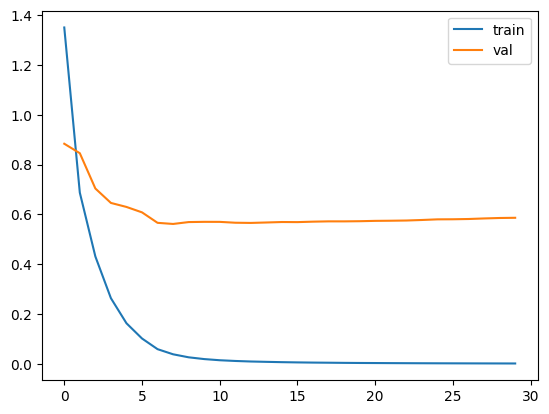

In [27]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

### 検証データで評価(本来はテストデータ)

In [28]:
model.eval()
val_outputs = model(X_val)
_, predicted = torch.max(val_outputs, dim=-1)

In [29]:
predicted

tensor([[7, 7, 7, 1, 7, 7, 1, 1],
        [7, 7, 7, 1, 7, 1, 1, 7],
        [7, 1, 7, 7, 7, 7, 1, 7],
        [7, 1, 7, 7, 7, 7, 7, 1],
        [7, 7, 7, 7, 2, 5, 7, 7],
        [7, 7, 7, 7, 4, 7, 7, 1]])

In [30]:
for sentence, predicted_label, val_label in zip(val_sentences, predicted, y_val):
    words = sentence.split()
    decodered_labels = label_encoder.inverse_transform(predicted_label[:len(words)]-1)
    original_labels = label_encoder.inverse_transform(val_label[:len(words)]-1)
    print(f'original sentence : {sentence}')
    print(f'predicted labels:{decodered_labels}')
    print(f'true labels: {original_labels}')
    print()

original sentence : He lives in Los Angeles .
predicted labels:['O' 'O' 'O' 'B-geo' 'O' 'O']
true labels: ['O' 'O' 'O' 'B-geo' 'I-geo' 'O']

original sentence : She is from Australia .
predicted labels:['O' 'O' 'O' 'B-geo' 'O']
true labels: ['O' 'O' 'O' 'B-geo' 'O']

original sentence : The Great Barrier Reef is in Australia .
predicted labels:['O' 'B-geo' 'O' 'O' 'O' 'O' 'B-geo' 'O']
true labels: ['O' 'B-geo' 'I-geo' 'I-geo' 'O' 'O' 'B-geo' 'O']

original sentence : The Amazon is the largest rainforest .
predicted labels:['O' 'B-geo' 'O' 'O' 'O' 'O' 'O']
true labels: ['O' 'B-geo' 'O' 'O' 'O' 'O' 'O']

original sentence : He works for the United Nations .
predicted labels:['O' 'O' 'O' 'O' 'B-org' 'I-org' 'O']
true labels: ['O' 'O' 'O' 'O' 'B-org' 'I-org' 'O']

original sentence : Berlin is the capital of Germany .
predicted labels:['O' 'O' 'O' 'O' 'I-geo' 'O' 'O']
true labels: ['B-geo' 'O' 'O' 'O' 'O' 'B-geo' 'O']



### 補足 : TensorDataset 

In [31]:
train_dataset = TensorDataset(X_train, y_train)

In [32]:
train_dataset[0]

(tensor([94, 51, 95, 96, 97, 98,  7,  0,  0,  0]),
 tensor([7, 7, 7, 1, 7, 7, 7, 0, 0, 0]))

In [33]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
next(iter(train_loader))

[tensor([[78, 79, 80, 62, 81,  7,  0,  0,  0,  0],
         [17, 23, 33, 19, 34, 35,  7,  0,  0,  0]]),
 tensor([[3, 6, 7, 7, 7, 7, 0, 0, 0, 0],
         [7, 7, 7, 7, 2, 5, 7, 0, 0, 0]])]